In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pbl-project-dataset/CMAPSSData/RUL_FD002.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/test_FD003.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/Damage Propagation Modeling.pdf
/kaggle/input/pbl-project-dataset/CMAPSSData/readme.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/train_FD003.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/test_FD004.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/train_FD004.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/test_FD002.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/train_FD001.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/train_FD002.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/RUL_FD001.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/RUL_FD004.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/RUL_FD003.txt
/kaggle/input/pbl-project-dataset/CMAPSSData/test_FD001.txt


In [2]:
"""
KAGGLE NOTEBOOK 1: DATA PREPROCESSING & FEATURE ENGINEERING
Run this on Kaggle with the C-MAPSS dataset
"""

import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

def load_cmapss_data(file_path):
    """Load C-MAPSS data and assign column names"""
    
    # Define column names
    columns = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3']
    columns += [f'sensor_{i}' for i in range(1, 22)]  # 21 sensors
    
    # Load data (space-separated)
    df = pd.read_csv(file_path, sep='\s+', header=None, names=columns)
    
    return df

# Load training and test data
train_df = load_cmapss_data('/kaggle/input/pbl-project-dataset/CMAPSSData/train_FD001.txt')
test_df = load_cmapss_data('/kaggle/input/pbl-project-dataset/CMAPSSData/test_FD001.txt')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nNumber of engines in training: {train_df['unit'].nunique()}")
print(f"Number of engines in test: {test_df['unit'].nunique()}")

# ============================================================================
# STEP 2: CALCULATE RUL (Remaining Useful Life)
# ============================================================================

def add_rul(df):
    """Calculate Remaining Useful Life for each engine"""
    
    # Group by unit and calculate max cycle for each engine
    max_cycles = df.groupby('unit')['cycle'].max().reset_index()
    max_cycles.columns = ['unit', 'max_cycle']
    
    # Merge and calculate RUL
    df = df.merge(max_cycles, on='unit', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df = df.drop('max_cycle', axis=1)
    
    return df

train_df = add_rul(train_df)

print("\nRUL Statistics:")
print(train_df['RUL'].describe())

# ============================================================================
# STEP 3: IDENTIFY AND REMOVE STATIC FEATURES
# ============================================================================

def identify_static_features(df, threshold=0.001):
    """Identify sensors with very low variance (likely static/constant)"""
    
    sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
    
    static_sensors = []
    for col in sensor_cols:
        variance = df[col].var()
        if variance < threshold:
            static_sensors.append(col)
            print(f"{col}: variance = {variance:.6f} (STATIC)")
    
    return static_sensors

static_sensors = identify_static_features(train_df)

# Remove static sensors
operational_cols = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_cols = [col for col in train_df.columns if col.startswith('sensor_') and col not in static_sensors]

print(f"\nOriginal sensor count: 21")
print(f"Static sensors removed: {len(static_sensors)}")
print(f"Active sensors: {len(sensor_cols)}")
print(f"Active sensors: {sensor_cols}")

# ============================================================================
# STEP 4: DATA NORMALIZATION
# ============================================================================

def normalize_data(train_df, test_df, sensor_cols):
    """Normalize sensor data using MinMaxScaler (fit on training data only)"""
    
    scaler = MinMaxScaler()
    
    # Fit scaler on training data
    train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
    
    # Transform test data
    test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])
    
    return train_df, test_df, scaler

train_df_scaled, test_df_scaled, scaler = normalize_data(
    train_df.copy(), 
    test_df.copy(), 
    sensor_cols
)

print("\nNormalization complete!")
print(f"Scaler fitted on {len(sensor_cols)} sensors")

# ============================================================================
# STEP 5: CREATE "NORMAL" DATA SUBSET
# ============================================================================

def create_normal_data(df, rul_threshold=125):
    """
    Extract 'normal' operating data (early life cycles)
    This data will be used to train all models
    """
    
    # Only keep data where RUL is high (engine is healthy)
    normal_df = df[df['RUL'] > rul_threshold].copy()
    
    print(f"\nOriginal data points: {len(df)}")
    print(f"Normal data points (RUL > {rul_threshold}): {len(normal_df)}")
    print(f"Percentage: {100 * len(normal_df) / len(df):.2f}%")
    
    return normal_df

normal_df = create_normal_data(train_df_scaled, rul_threshold=125)

# ============================================================================
# STEP 6: CREATE SLIDING WINDOWS FOR VAE
# ============================================================================

def create_windows(data, window_size=30):
    """
    Create sliding windows from time series data
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, n_features)
    window_size : int, size of each window
    
    Returns:
    --------
    windows : array, shape (n_windows, window_size, n_features)
    """
    
    windows = []
    
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        windows.append(window)
    
    return np.array(windows)

def create_windows_per_engine(df, sensor_cols, window_size=30):
    """Create windows for each engine separately"""
    
    all_windows = []
    
    for unit in df['unit'].unique():
        unit_data = df[df['unit'] == unit][sensor_cols].values
        
        # Only create windows if we have enough data
        if len(unit_data) >= window_size:
            windows = create_windows(unit_data, window_size)
            all_windows.append(windows)
    
    # Concatenate all windows
    all_windows = np.vstack(all_windows)
    
    return all_windows

# Create windows for normal data
WINDOW_SIZE = 30
normal_windows = create_windows_per_engine(normal_df, sensor_cols, WINDOW_SIZE)

print(f"\nWindows created for VAE training:")
print(f"Shape: {normal_windows.shape}")
print(f"(n_windows, window_size, n_features) = ({normal_windows.shape[0]}, {normal_windows.shape[1]}, {normal_windows.shape[2]})")

# ============================================================================
# STEP 7: SAVE PREPROCESSED DATA
# ============================================================================

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature information
feature_info = {
    'sensor_cols': sensor_cols,
    'static_sensors': static_sensors,
    'window_size': WINDOW_SIZE,
    'operational_cols': operational_cols
}

with open('feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

# Save processed data
train_df_scaled.to_pickle('train_scaled.pkl')
test_df_scaled.to_pickle('test_scaled.pkl')
normal_df.to_pickle('normal_data.pkl')

# Save windows for VAE
np.save('normal_windows.npy', normal_windows)

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print("\nSaved files:")
print("- scaler.pkl")
print("- feature_info.pkl")
print("- train_scaled.pkl")
print("- test_scaled.pkl")
print("- normal_data.pkl")
print("- normal_windows.npy")
print("\n✓ Ready for model training!")

Training data shape: (20631, 26)
Test data shape: (13096, 26)

Number of engines in training: 100
Number of engines in test: 100

RUL Statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64
sensor_1: variance = 0.000000 (STATIC)
sensor_5: variance = 0.000000 (STATIC)
sensor_6: variance = 0.000002 (STATIC)
sensor_10: variance = 0.000000 (STATIC)
sensor_16: variance = 0.000000 (STATIC)
sensor_18: variance = 0.000000 (STATIC)
sensor_19: variance = 0.000000 (STATIC)

Original sensor count: 21
Static sensors removed: 7
Active sensors: 14
Active sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

Normalization complete!
Scaler fitted on 14 sensors

Original data points: 20631
Normal data points (RUL > 12

In [3]:
"""
KAGGLE NOTEBOOK 2: ARIMA MODEL TRAINING
Run this AFTER the preprocessing notebook
"""

import numpy as np
import pandas as pd
import pickle
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: LOAD PREPROCESSED DATA
# ============================================================================

# Load normal data
normal_df = pd.read_pickle('normal_data.pkl')

# Load feature info
with open('feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)

sensor_cols = feature_info['sensor_cols']

print("Data loaded successfully!")
print(f"Normal data shape: {normal_df.shape}")
print(f"Sensors: {sensor_cols}")

# ============================================================================
# STEP 2: SELECT KEY SENSOR FOR ARIMA
# ============================================================================

# For ARIMA, we'll use a single sensor that shows good degradation patterns
# Sensor 4, 7, 11, and 12 are typically good choices for turbofan engines

KEY_SENSOR = 'sensor_4'  # You can experiment with different sensors

# Select data from a single engine for ARIMA training
TRAIN_UNIT = 1

# Get time series for the selected sensor
sensor_data = normal_df[normal_df['unit'] == TRAIN_UNIT][KEY_SENSOR].values

print(f"\nARIMA training on: {KEY_SENSOR}")
print(f"Training unit: {TRAIN_UNIT}")
print(f"Data points: {len(sensor_data)}")

# ============================================================================
# STEP 3: TRAIN ARIMA MODEL
# ============================================================================

def train_arima_model(data, order=(5, 1, 0)):
    """
    Train ARIMA model on time series data
    
    Parameters:
    -----------
    data : array-like, time series data
    order : tuple (p, d, q)
        p: autoregressive order
        d: differencing order
        q: moving average order
    
    Returns:
    --------
    fitted_model : ARIMAResults object
    """
    
    print(f"\nTraining ARIMA{order}...")
    
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    
    print("Training complete!")
    print(f"AIC: {fitted_model.aic:.2f}")
    print(f"BIC: {fitted_model.bic:.2f}")
    
    return fitted_model

# Train the model
arima_model = train_arima_model(sensor_data, order=(5, 1, 0))

# ============================================================================
# STEP 4: TEST ARIMA ANOMALY DETECTION
# ============================================================================

def get_arima_anomaly_score(model, actual_value, history_window):
    """
    Calculate anomaly score using ARIMA
    
    Parameters:
    -----------
    model : fitted ARIMA model
    actual_value : float, the actual observed value
    history_window : array, recent historical values
    
    Returns:
    --------
    anomaly_score : float, absolute prediction error
    """
    
    # Make prediction
    forecast = model.forecast(steps=1)[0]
    
    # Calculate residual (error)
    residual = abs(actual_value - forecast)
    
    return residual

# Test on validation data
test_data = normal_df[normal_df['unit'] == 2][KEY_SENSOR].values[:100]

print("\nTesting ARIMA anomaly detection:")
anomaly_scores = []

for i in range(20, len(test_data)):
    history = test_data[i-20:i]
    actual = test_data[i]
    
    # For this test, we'll use the trained model
    # In production, you'd update the model with new data
    score = abs(actual - arima_model.forecast(steps=1)[0])
    anomaly_scores.append(score)

print(f"Average anomaly score: {np.mean(anomaly_scores):.6f}")
print(f"Max anomaly score: {np.max(anomaly_scores):.6f}")

# ============================================================================
# STEP 5: SAVE ARIMA MODEL
# ============================================================================

# Save model configuration
arima_config = {
    'model': arima_model,
    'key_sensor': KEY_SENSOR,
    'order': (5, 1, 0),
    'train_unit': TRAIN_UNIT,
    'training_data_mean': sensor_data.mean(),
    'training_data_std': sensor_data.std()
}

with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_config, f)

print("\n" + "="*60)
print("ARIMA MODEL TRAINING COMPLETE!")
print("="*60)
print("\nSaved files:")
print("- arima_model.pkl")
print(f"\nModel trained on {KEY_SENSOR}")
print(f"Order: (5, 1, 0)")
print("\n✓ Ready for deployment!")

Data loaded successfully!
Normal data shape: (8031, 27)
Sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

ARIMA training on: sensor_4
Training unit: 1
Data points: 66

Training ARIMA(5, 1, 0)...
Training complete!
AIC: -194.76
BIC: -181.72

Testing ARIMA anomaly detection:
Average anomaly score: 0.064629
Max anomaly score: 0.208850

ARIMA MODEL TRAINING COMPLETE!

Saved files:
- arima_model.pkl

Model trained on sensor_4
Order: (5, 1, 0)

✓ Ready for deployment!


In [5]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 10.7 MB/s eta 0:00:00


In [6]:
"""
KAGGLE NOTEBOOK 3: KALMAN FILTER TRAINING
Run this AFTER the preprocessing notebook
"""

import numpy as np
import pandas as pd
import pickle
from pykalman import KalmanFilter
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: LOAD PREPROCESSED DATA
# ============================================================================

# Load normal data
normal_df = pd.read_pickle('normal_data.pkl')

# Load feature info
with open('feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)

sensor_cols = feature_info['sensor_cols']

print("Data loaded successfully!")
print(f"Normal data shape: {normal_df.shape}")

# ============================================================================
# STEP 2: SELECT SENSORS FOR KALMAN FILTER
# ============================================================================

# Kalman Filter works with multiple correlated sensors
# We'll select 3-4 key sensors that show good correlation
KEY_SENSORS = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7']

# Filter to only include sensors that exist in our data
KEY_SENSORS = [s for s in KEY_SENSORS if s in sensor_cols]

print(f"\nKalman Filter will use {len(KEY_SENSORS)} sensors:")
print(KEY_SENSORS)

# Get training data (from multiple engines for robustness)
train_units = normal_df['unit'].unique()[:10]  # Use first 10 engines
kalman_train_data = normal_df[normal_df['unit'].isin(train_units)][KEY_SENSORS].values

print(f"\nTraining data shape: {kalman_train_data.shape}")

# ============================================================================
# STEP 3: TRAIN KALMAN FILTER
# ============================================================================

def train_kalman_filter(data, n_dim_state=None):
    """
    Train Kalman Filter using EM algorithm
    
    Parameters:
    -----------
    data : array-like, shape (n_timesteps, n_dim_obs)
    n_dim_state : int, dimension of hidden state (default: same as observations)
    
    Returns:
    --------
    kf : fitted KalmanFilter object
    """
    
    n_dim_obs = data.shape[1]
    if n_dim_state is None:
        n_dim_state = n_dim_obs
    
    print(f"\nTraining Kalman Filter...")
    print(f"Observation dimension: {n_dim_obs}")
    print(f"State dimension: {n_dim_state}")
    
    # Initialize Kalman Filter
    kf = KalmanFilter(
        n_dim_obs=n_dim_obs,
        n_dim_state=n_dim_state,
        initial_state_mean=np.zeros(n_dim_state),
        em_vars=['transition_matrices', 'observation_matrices',
                 'transition_covariance', 'observation_covariance',
                 'initial_state_mean', 'initial_state_covariance']
    )
    
    # Train using EM algorithm
    kf = kf.em(data, n_iter=10)
    
    print("Training complete!")
    
    return kf

# Train the Kalman Filter
kalman_filter = train_kalman_filter(kalman_train_data)

# ============================================================================
# STEP 4: DEFINE ANOMALY DETECTION FUNCTION
# ============================================================================

def calculate_mahalanobis_distance(residual, covariance):
    """
    Calculate Mahalanobis distance for anomaly detection
    
    Parameters:
    -----------
    residual : array, prediction residual
    covariance : array, covariance matrix
    
    Returns:
    --------
    distance : float, Mahalanobis distance
    """
    
    # Add small value to diagonal for numerical stability
    covariance_stable = covariance + np.eye(covariance.shape[0]) * 1e-6
    
    # Calculate Mahalanobis distance
    inv_covariance = np.linalg.inv(covariance_stable)
    distance = np.sqrt(residual.T @ inv_covariance @ residual)
    
    return distance

def get_kalman_anomaly_score(kf, observation, filtered_state_mean, filtered_state_covariance):
    """
    Calculate anomaly score using Kalman Filter
    
    Parameters:
    -----------
    kf : trained KalmanFilter object
    observation : array, current observation
    filtered_state_mean : array, current state mean
    filtered_state_covariance : array, current state covariance
    
    Returns:
    --------
    anomaly_score : float, Mahalanobis distance of innovation
    next_state_mean : array, updated state mean
    next_state_covariance : array, updated state covariance
    """
    
    # Predict next observation
    predicted_observation = kf.observation_matrices @ filtered_state_mean
    
    # Calculate innovation (residual)
    innovation = observation - predicted_observation
    
    # Calculate innovation covariance
    innovation_covariance = (
        kf.observation_matrices @ 
        filtered_state_covariance @ 
        kf.observation_matrices.T + 
        kf.observation_covariance
    )
    
    # Calculate Mahalanobis distance
    anomaly_score = calculate_mahalanobis_distance(innovation, innovation_covariance)
    
    # Update state
    next_state_mean, next_state_covariance = kf.filter_update(
        filtered_state_mean,
        filtered_state_covariance,
        observation
    )
    
    return anomaly_score, next_state_mean, next_state_covariance

# ============================================================================
# STEP 5: TEST KALMAN FILTER
# ============================================================================

# Test on validation data
test_unit = 5
test_data = normal_df[normal_df['unit'] == test_unit][KEY_SENSORS].values[:100]

print("\nTesting Kalman Filter anomaly detection:")

# Initialize filter state
filtered_state_means, filtered_state_covariances = kalman_filter.filter(test_data[:20])
current_state_mean = filtered_state_means[-1]
current_state_covariance = filtered_state_covariances[-1]

# Test on remaining data
anomaly_scores = []
for i in range(20, len(test_data)):
    observation = test_data[i]
    
    score, current_state_mean, current_state_covariance = get_kalman_anomaly_score(
        kalman_filter,
        observation,
        current_state_mean,
        current_state_covariance
    )
    
    anomaly_scores.append(score)

print(f"Average anomaly score: {np.mean(anomaly_scores):.6f}")
print(f"Max anomaly score: {np.max(anomaly_scores):.6f}")
print(f"Std anomaly score: {np.std(anomaly_scores):.6f}")

# ============================================================================
# STEP 6: SAVE KALMAN FILTER MODEL
# ============================================================================

kalman_config = {
    'model': kalman_filter,
    'key_sensors': KEY_SENSORS,
    'n_dim_obs': len(KEY_SENSORS),
    'training_data_mean': kalman_train_data.mean(axis=0),
    'training_data_std': kalman_train_data.std(axis=0),
    'anomaly_threshold': np.mean(anomaly_scores) + 3 * np.std(anomaly_scores)
}

with open('kalman_model.pkl', 'wb') as f:
    pickle.dump(kalman_config, f)

print("\n" + "="*60)
print("KALMAN FILTER TRAINING COMPLETE!")
print("="*60)
print("\nSaved files:")
print("- kalman_model.pkl")
print(f"\nModel trained on {len(KEY_SENSORS)} sensors:")
print(KEY_SENSORS)
print(f"\nSuggested anomaly threshold: {kalman_config['anomaly_threshold']:.4f}")
print("\n✓ Ready for deployment!")

Data loaded successfully!
Normal data shape: (8031, 27)

Kalman Filter will use 4 sensors:
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7']

Training data shape: (876, 4)

Training Kalman Filter...
Observation dimension: 4
State dimension: 4
Training complete!

Testing Kalman Filter anomaly detection:
Average anomaly score: 1.917846
Max anomaly score: 3.407534
Std anomaly score: 0.626994

KALMAN FILTER TRAINING COMPLETE!

Saved files:
- kalman_model.pkl

Model trained on 4 sensors:
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7']

Suggested anomaly threshold: 3.7988

✓ Ready for deployment!


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Windows shape: (5239, 30, 14)
Window size: 30
Number of features: 14

Training windows: (4191, 30, 14)
Validation windows: (1048, 30, 14)

Building VAE...

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 30, 64)    │     20,224 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 32)        │     12,416 │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      1,056 │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_9          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,752 (135.75 KB)

 Trainable params: 34,752 (135.75 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 30, 14)         │           910 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,606 (135.18 KB)

 Trainable params: 34,606 (135.18 KB)

 Non-trainable params: 0 (0.00 B)


Training VAE...
Batch size: 32
Max epochs: 50
Epoch 1/50


I0000 00:00:1762919938.911903     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - kl_loss: 2.0567 - loss: 8.4656 - reconstruction_loss: 8.2599 - val_kl_loss: 0.5143 - val_loss: 3.3772 - val_reconstruction_loss: 3.3258 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 2.5130 - loss: 3.2782 - reconstruction_loss: 3.0269 - val_kl_loss: 1.2116 - val_loss: 3.0882 - val_reconstruction_loss: 2.9670 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 2.2338 - loss: 2.6980 - reconstruction_loss: 2.4746 - val_kl_loss: 1.3013 - val_loss: 2.5705 - val_reconstruction_loss: 2.4404 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 2.0327 - loss: 2.4550 - reconstruction_loss: 2.2517 - val_kl_loss: 1.3761 - val_loss: 2.3247 - val_reconstruction_loss: 2.1871 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 1.9201 - loss: 2.2993 - reconstruction_loss: 2.1073 - val_kl_loss: 1.4376 - val_loss: 2

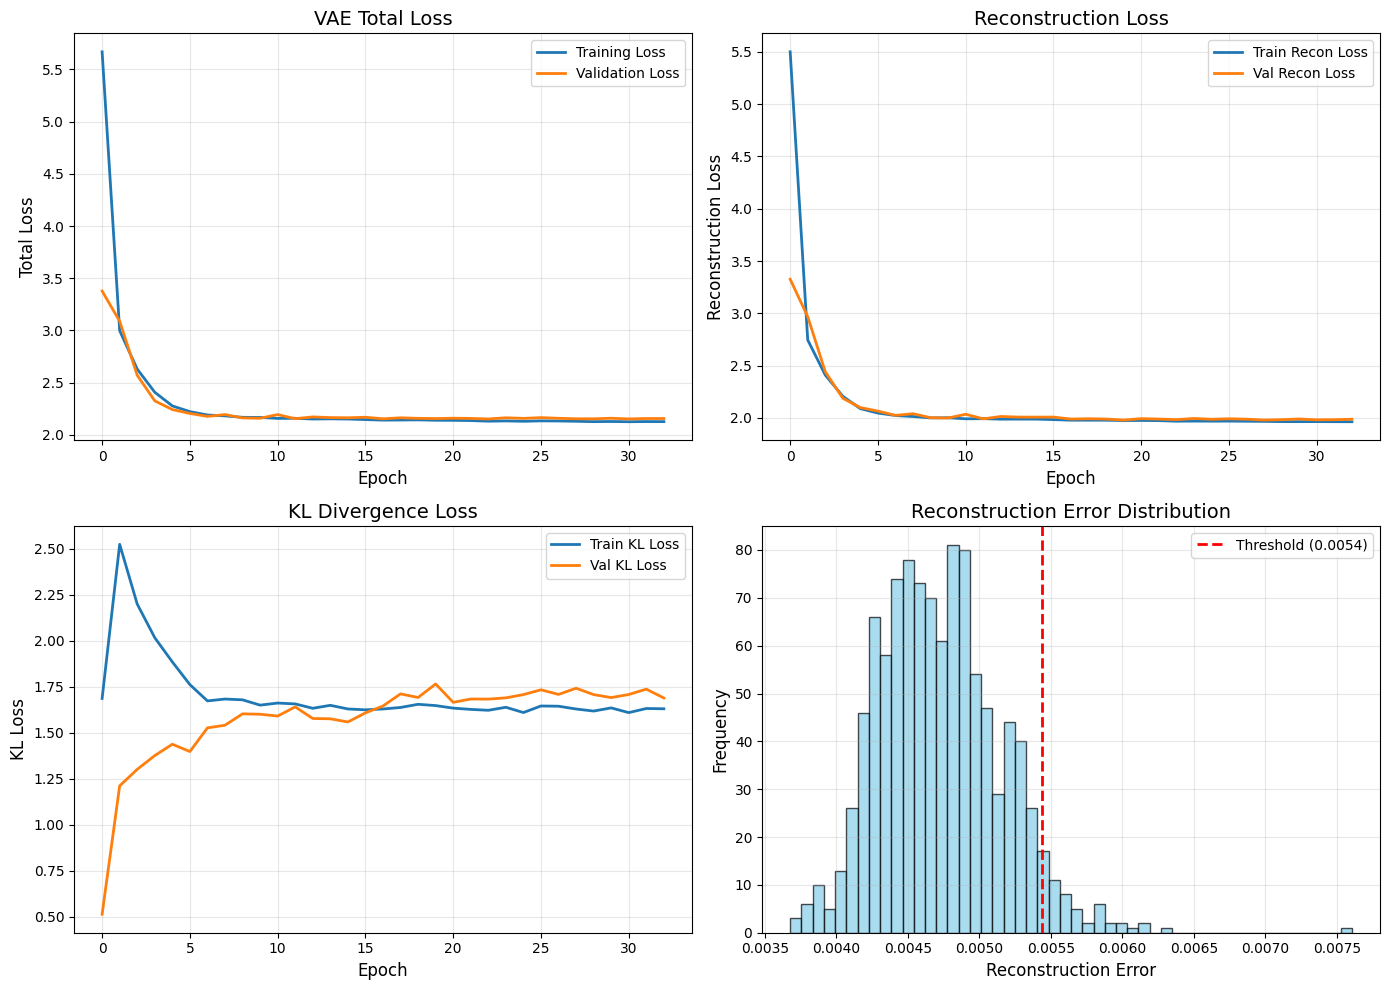


Plot saved: vae_training_results.png

Testing inference functions...
Mean anomaly score over all val windows: 0.004715

Top 3 contributing sensors (for first val window):
  sensor_3: 0.085416
  sensor_2: 0.070031
  sensor_21: 0.065005

VAE TRAINING COMPLETE!

Saved files:
- vae_model.keras
- vae_encoder.keras
- vae_decoder.keras
- vae_config.pkl
- vae_training_results.png

Model details:
- Window size: 30
- Features: 14
- Latent dimension: 16
- LSTM units: 64
- Anomaly threshold: 0.005436

✓ Ready for deployment!

LOADING EXAMPLE

To load the model later, use:

# Load the saved model
# You must pass the custom classes!
vae_loaded = keras.models.load_model(
    'vae_model.keras', 
    custom_objects={'VAE': VAE, 'Sampling': Sampling}
)

# Or load encoder/decoder separately
encoder_loaded = keras.models.load_model(
    'vae_encoder.keras', 
    custom_objects={'Sampling': Sampling}
)
decoder_loaded = keras.models.load_model('vae_decoder.keras')

# Load config
import pickle
with open('va

In [18]:
"""
KAGGLE NOTEBOOK 4: VAE (Variational Autoencoder) TRAINING
Run this AFTER the preprocessing notebook
"""
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from keras import ops
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# ============================================================================
# STEP 1: LOAD PREPROCESSED DATA
# ============================================================================

# Load windowed normal data
normal_windows = np.load('normal_windows.npy')

# Load feature info
with open('feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)

WINDOW_SIZE = feature_info['window_size']
sensor_cols = feature_info['sensor_cols']
N_FEATURES = len(sensor_cols)

print(f"Windows shape: {normal_windows.shape}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Number of features: {N_FEATURES}")

# Split into train and validation
val_split = 0.2
split_idx = int(len(normal_windows) * (1 - val_split))

train_windows = normal_windows[:split_idx]
val_windows = normal_windows[split_idx:]

print(f"\nTraining windows: {train_windows.shape}")
print(f"Validation windows: {val_windows.shape}")

# ============================================================================
# STEP 2: BUILD VAE ARCHITECTURE
# ============================================================================

# Hyperparameters
LATENT_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001


# === CORRECTED Sampling LAYER ===
class Sampling(layers.Layer):
    """Sampling layer for VAE reparameterization trick"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        
        # Use keras.random.normal (NOT keras.ops.random.normal)
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        
        # Use ops.exp for exponentiation
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_encoder(window_size, n_features, latent_dim, lstm_units):
    """Build VAE Encoder"""
    
    encoder_inputs = keras.Input(shape=(window_size, n_features), name='encoder_input')
    # LSTM layers
    x = layers.LSTM(lstm_units, return_sequences=True)(encoder_inputs)
    x = layers.LSTM(lstm_units // 2)(x)
    x = layers.Dense(32, activation='relu')(x)
    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    # Sampling
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder


def build_decoder(window_size, n_features, latent_dim, lstm_units):
    """Build VAE Decoder"""
    
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
    # Expand latent vector to sequence
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.RepeatVector(window_size)(x)
    # LSTM layers
    x = layers.LSTM(lstm_units // 2, return_sequences=True)(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    # Output layer
    decoder_outputs = layers.TimeDistributed(
        layers.Dense(n_features, activation='sigmoid'),
        name='decoder_output'
    )(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder


# === CORRECTED VAE MODEL WITH CUSTOM TRAIN_STEP ===
class VAE(keras.Model):
    """VAE model with custom training step"""

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # data argument is (x, y), but VAEs are unsupervised, so y is ignored.
        # We pass train_windows as both x and y in fit(), so data[0] is correct.
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE per element, then sum and mean)
            reconstruction_loss = ops.mean(
                ops.sum(
                    ops.square(data - reconstruction),
                    axis=(1, 2)
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * ops.mean(
                ops.sum(
                    1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var),
                    axis=1
                )
            )
            
            # Total loss
            total_loss = reconstruction_loss + 0.1 * kl_loss
            
        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Validation step"""
        if isinstance(data, tuple):
            data = data[0]
            
        # Forward pass
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        # Reconstruction loss
        reconstruction_loss = ops.mean(
            ops.sum(
                ops.square(data - reconstruction),
                axis=(1, 2)
            )
        )
        
        # KL divergence loss
        kl_loss = -0.5 * ops.mean(
            ops.sum(
                1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var),
                axis=1
            )
        )
        
        # Total loss
        total_loss = reconstruction_loss + 0.1 * kl_loss
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        """Forward pass for inference"""
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)


# Build encoder and decoder
print("\nBuilding VAE...")
encoder = build_encoder(WINDOW_SIZE, N_FEATURES, LATENT_DIM, LSTM_UNITS)
decoder = build_decoder(WINDOW_SIZE, N_FEATURES, LATENT_DIM, LSTM_UNITS)

# Create VAE model
vae = VAE(encoder, decoder)

# Display model architecture
print("\nEncoder Summary:")
encoder.summary()
print("\nDecoder Summary:")
decoder.summary()

# ============================================================================
# STEP 3: TRAIN VAE
# ============================================================================

# Compile model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("\nTraining VAE...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")

history = vae.fit(
    train_windows,
    train_windows,  # Pass x=train_windows, y=train_windows
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_windows, val_windows), # Pass val_x, val_y
    callbacks=callbacks,
    verbose=1
)

# ============================================================================
# STEP 4: EVALUATE VAE
# ============================================================================

print("\nEvaluating VAE...")

# Calculate reconstruction errors on validation set
reconstructed = vae.predict(val_windows, verbose=0)
reconstruction_errors = np.mean(np.square(val_windows - reconstructed), axis=(1, 2))

print(f"\nReconstruction Error Statistics:")
print(f"Mean: {reconstruction_errors.mean():.6f}")
print(f"Std: {reconstruction_errors.std():.6f}")
print(f"Min: {reconstruction_errors.min():.6f}")
print(f"Max: {reconstruction_errors.max():.6f}")
print(f"95th percentile: {np.percentile(reconstruction_errors, 95):.6f}")

# Set anomaly threshold (95th percentile of training errors)
anomaly_threshold = np.percentile(reconstruction_errors, 95)
print(f"\nSuggested anomaly threshold: {anomaly_threshold:.6f}")

# Plot training history
plt.figure(figsize=(14, 10))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('VAE Total Loss', fontsize=14)
plt.grid(True, alpha=0.3)

# Reconstruction loss
plt.subplot(2, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Train Recon Loss', linewidth=2)
plt.plot(history.history['val_reconstruction_loss'], label='Val Recon Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Reconstruction Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Reconstruction Loss', fontsize=14)
plt.grid(True, alpha=0.3)

# KL loss
plt.subplot(2, 2, 3)
plt.plot(history.history['kl_loss'], label='Train KL Loss', linewidth=2)
plt.plot(history.history['val_kl_loss'], label='Val KL Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('KL Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('KL Divergence Loss', fontsize=14)
plt.grid(True, alpha=0.3)

# Reconstruction error distribution
plt.subplot(2, 2, 4)
plt.hist(reconstruction_errors, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(anomaly_threshold, color='r', linestyle='--', linewidth=2,
            label=f'Threshold ({anomaly_threshold:.4f})')
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.title('Reconstruction Error Distribution', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vae_training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: vae_training_results.png")

# ============================================================================
# STEP 5: DEFINE INFERENCE FUNCTIONS
# ============================================================================

def get_vae_anomaly_score(vae_model, input_window):
    """
    Calculate anomaly score using VAE
    
    Parameters:
    -----------
    vae_model : trained VAE model
    input_window : array, shape (window_size, n_features) or (1, window_size, n_features)
    
    Returns:
    --------
    anomaly_score : float, mean squared reconstruction error
    """
    
    # Ensure correct shape
    if len(input_window.shape) == 2:
        input_window = np.expand_dims(input_window, axis=0)
        
    # Get reconstruction
    reconstructed = vae_model.predict(input_window, verbose=0)
    
    # Calculate MSE
    mse = np.mean(np.square(input_window - reconstructed))
    
    return float(mse)


def get_vae_explanation(vae_model, input_window, sensor_names):
    """
    Get per-sensor reconstruction errors for explainability
    
    Parameters:
    -----------
    vae_model : trained VAE model
    input_window : array, shape (window_size, n_features) or (1, window_size, n_features)
    sensor_names : list of sensor names
    
    Returns:
    --------
    explanation : dict, mapping sensor names to their error scores
    """
    
    # Ensure correct shape
    if len(input_window.shape) == 2:
        input_window = np.expand_dims(input_window, axis=0)
        
    # Get reconstruction
    reconstructed = vae_model.predict(input_window, verbose=0)
    
    # Calculate per-sensor error (mean absolute error over time)
    # We take the first item [0] assuming we're explaining one window at a time
    # even if a batch was passed.
    per_sensor_error = np.mean(np.abs(input_window[0] - reconstructed[0]), axis=0)
    
    # Create explanation dictionary
    explanation = {
        sensor: float(error)
        for sensor, error in zip(sensor_names, per_sensor_error)
    }
    
    return explanation


# Test functions
print("\nTesting inference functions...")
test_window = val_windows

# Calculate score for all validation windows
anomaly_score = get_vae_anomaly_score(vae, test_window)
print(f"Mean anomaly score over all val windows: {anomaly_score:.6f}")

# Get explanation for just the *first* validation window
explanation = get_vae_explanation(vae, test_window[0], sensor_cols)
print(f"\nTop 3 contributing sensors (for first val window):")
sorted_sensors = sorted(explanation.items(), key=lambda x: x[1], reverse=True)
for sensor, error in sorted_sensors[:3]:
    print(f"  {sensor}: {error:.6f}")

# ============================================================================
# STEP 6: SAVE VAE MODEL
# ============================================================================

# Save the full VAE model
vae.save('vae_model.keras')  # Use .keras format for Keras 3

# Save encoder and decoder separately
encoder.save('vae_encoder.keras')
decoder.save('vae_decoder.keras')

# Save model configuration
vae_config = {
    'window_size': WINDOW_SIZE,
    'n_features': N_FEATURES,
    'latent_dim': LATENT_DIM,
    'lstm_units': LSTM_UNITS,
    'sensor_cols': sensor_cols,
    'anomaly_threshold': float(anomaly_threshold),
    'training_history': {
        'final_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'final_reconstruction_loss': float(history.history['reconstruction_loss'][-1]),
        'final_kl_loss': float(history.history['kl_loss'][-1]),
        'epochs_trained': len(history.history['loss'])
    }
}

with open('vae_config.pkl', 'wb') as f:
    pickle.dump(vae_config, f)

print("\n" + "=" * 60)
print("VAE TRAINING COMPLETE!")
print("=" * 60)
print("\nSaved files:")
print("- vae_model.keras")
print("- vae_encoder.keras")
print("- vae_decoder.keras")
print("- vae_config.pkl")
print("- vae_training_results.png")
print(f"\nModel details:")
print(f"- Window size: {WINDOW_SIZE}")
print(f"- Features: {N_FEATURES}")
print(f"- Latent dimension: {LATENT_DIM}")
print(f"- LSTM units: {LSTM_UNITS}")
print(f"- Anomaly threshold: {anomaly_threshold:.6f}")
print("\n✓ Ready for deployment!")

# ============================================================================
# OPTIONAL: EXAMPLE OF LOADING THE MODEL
# ============================================================================

print("\n" + "=" * 60)
print("LOADING EXAMPLE")
print("=" * 60)
print("\nTo load the model later, use:")
print("""
# Load the saved model
# You must pass the custom classes!
vae_loaded = keras.models.load_model(
    'vae_model.keras', 
    custom_objects={'VAE': VAE, 'Sampling': Sampling}
)

# Or load encoder/decoder separately
encoder_loaded = keras.models.load_model(
    'vae_encoder.keras', 
    custom_objects={'Sampling': Sampling}
)
decoder_loaded = keras.models.load_model('vae_decoder.keras')

# Load config
import pickle
with open('vae_config.pkl', 'rb') as f:
    config = pickle.load(f)
    
anomaly_threshold = config['anomaly_threshold']

print("Loaded threshold:", anomaly_threshold)
""")